In [55]:
'''
Author: Sriram Yarlagadda + George Nakhleh
Date Created: 10/15/2016
Note: Please use Python 2.7
'''
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#os.chdir('C:\Users\syarlag1\Desktop\Loyola-SAH-Seasonality-Analysis')
os.chdir('C:\\Users\\gnakhleh\\Documents\\Loyola\\Loyola-SAH-Seasonality-Analysis')

%matplotlib inline

### Reading Data

In [2]:
os.chdir('./data')
dataFiles = os.listdir('.')
allDataDict = {}
# list of variables we need
varList = ['SCORE','SPRING','SUMMER','WINTER','FALL','FEMALE']
for dataFile in dataFiles:
    state = dataFile[-6:-4]
    allDataDict[state] = pd.read_stata(dataFile, columns=varList)

In [3]:
for key in allDataDict.keys(): #creating a new state identifier column
    allDataDict[key]['State'] = pd.Series([str(key)[:2]]*allDataDict[key].shape[0])
allStateData = pd.concat(allDataDict.values()) #combing into a single dataframe

In [4]:
allStateData.index = range(allStateData.shape[0])

### Data Preprocessing

In [5]:
allStateData.shape

(29708, 7)

In [6]:
allStateData.columns

Index([u'SCORE', u'SPRING', u'SUMMER', u'WINTER', u'FALL', u'FEMALE',
       u'State'],
      dtype='object')

In [7]:
np.sum(np.array(allStateData < 0), 0) # 88 values < 0 (invalid)

array([ 0,  0,  0,  0,  0, 88,  0])

In [8]:
np.sum(np.array(pd.isnull(allStateData)),0) # 226 NaNs

array([  0,   0,   0,   0,   0, 226,   0])

In [9]:
#Drop records with no season (where the sum of the season columns = 0)
for feature in allStateData.columns: 
    allStateData = allStateData[allStateData[feature] >= 0]

In [10]:
# continue with removing instances where all seasons are equal to 0
allStateData = allStateData.drop(allStateData[allStateData['FALL']+\
                                                  allStateData['WINTER']+\
                                                  allStateData['SUMMER']+\
                                                  allStateData['SPRING']== 0].index)

In [11]:
allStateData.shape

(29304, 7)

In [12]:
# creating a new "season" variable
allStateData.index = range(allStateData.shape[0]) # reindexing again to account for the removed rows
season = []
for iRow in range(allStateData.shape[0]):
    if allStateData['FALL'][iRow] == 1: season.append('FALL')
    if allStateData['SPRING'][iRow] == 1: season.append('SPRING')
    if allStateData['SUMMER'][iRow] == 1: season.append('SUMMER')
    if allStateData['WINTER'][iRow] == 1: season.append('WINTER')

allStateData['SEASON'] = pd.Series(season)

In [13]:
# saving an excel copy of the entire data for later use
os.chdir('./..')
allStateData.to_csv('allData.csv') # note that all data only includes the column subsets we need

### Seasonality

#### *Question*: Is there seasonality in the SAH Scores?

Let us first perform some quick data exploration

In [14]:
#count for each season
allStateData.SEASON.value_counts()

SPRING    7497
FALL      7450
WINTER    7390
SUMMER    6967
Name: SEASON, dtype: int64

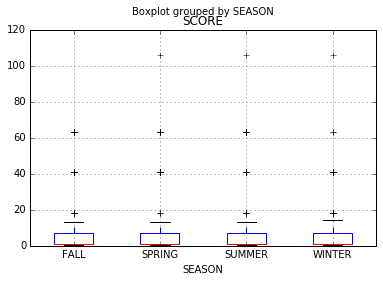

In [17]:
# boxplots of scores for each season
allStateData.boxplot(column='SCORE', by='SEASON')

Scores appear the same by season, though outliers cloud it a bit

**Analyzing scores**

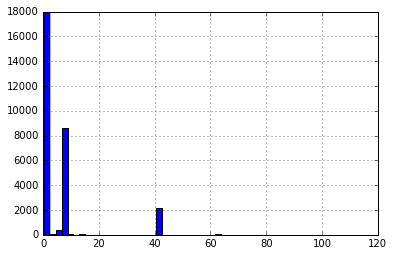

In [19]:
#Distribution of scores, overall
allStateData.SCORE.hist(bins=50)

In [38]:
#Same data on scores, but as a table of counts
allStateData.SCORE.value_counts().sort_index()

0.298197        467
0.463013          9
0.774142          3
0.932394      17022
1.447735        256
1.750672          3
2.225541        169
2.420563         41
3.455614          1
5.473947        385
6.958751       8607
8.499436          7
10.804901       100
13.065824        46
14.210769         1
18.065428        20
40.853809      2139
63.434006        25
106.059479        3
Name: SCORE, dtype: int64

In [36]:
#Expressed as percent of the overall data
allStateData.SCORE.value_counts().sort_index()/allStateData.shape[0]

0.298197      0.015936
0.463013      0.000307
0.774142      0.000102
0.932394      0.580876
1.447735      0.008736
1.750672      0.000102
2.225541      0.005767
2.420563      0.001399
3.455614      0.000034
5.473947      0.013138
6.958751      0.293714
8.499436      0.000239
10.804901     0.003413
13.065824     0.001570
14.210769     0.000034
18.065428     0.000683
40.853809     0.072993
63.434006     0.000853
106.059479    0.000102
Name: SCORE, dtype: float64

In [57]:
#Expressed as percent of the cumulative sum
#In other words, 59% of the records have a score of 0.93 or less

allStateData.SCORE.value_counts().sort_index().cumsum()/allStateData.shape[0]

0.298197      0.015936
0.463013      0.016244
0.774142      0.016346
0.932394      0.597222
1.447735      0.605958
1.750672      0.606061
2.225541      0.611828
2.420563      0.613227
3.455614      0.613261
5.473947      0.626399
6.958751      0.920113
8.499436      0.920352
10.804901     0.923765
13.065824     0.925334
14.210769     0.925369
18.065428     0.926051
40.853809     0.999044
63.434006     0.999898
106.059479    1.000000
Name: SCORE, dtype: float64

### 1-way ANOVA test
Determining whether there's a meaningful difference in scores by season

In [56]:
# creating seperate tables for each season for later use for anova
FALLData = allStateData[allStateData['SEASON'] == 'FALL']['SCORE']
SUMMERData = allStateData[allStateData['SEASON'] == 'SUMMER']['SCORE']
SPRINGData = allStateData[allStateData['SEASON'] == 'SPRING']['SCORE']
WINTERData = allStateData[allStateData['SEASON'] == 'WINTER']['SCORE']

stats.f_oneway(FALLData, SUMMERData, SPRINGData, WINTERData)

F_onewayResult(statistic=2.6621598986193655, pvalue=0.046311753389164698)

**Analysis of outlier records and w/ outliers removed**  
Outlier defined as a score of greater than 40 (~8% of the data)

In [50]:
allStateData_no_outliers = allStateData[allStateData['SCORE'] < 40]

In [51]:
pd.crosstab(allStateData_no_outliers['SCORE'], allStateData_no_outliers['SEASON'])

SEASON,FALL,SPRING,SUMMER,WINTER
SCORE,,,,
0.298197,105,130,103,129
0.463013,1,2,4,2
0.774142,0,3,0,0
0.932394,4311,4364,4059,4288
1.447735,64,72,56,64
1.750672,1,1,1,0
2.225541,45,45,37,42
2.420563,14,11,9,7
3.455614,0,1,0,0


In [52]:
#Mean scores for each season, with outliers removed
allStateData_no_outliers[['SCORE', 'SEASON']].groupby('SEASON').aggregate(np.mean)

,SCORE
SEASON,
FALL,2.990677
SPRING,2.964716
SUMMER,2.975229
WINTER,3.006950


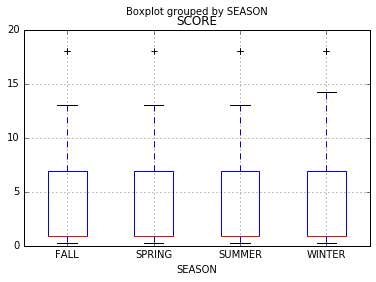

In [58]:
#Boxplot with outliers removed
allStateData_no_outliers.boxplot(column='SCORE', by='SEASON')

Even with outliers removed, the scores don't vary by season

In [54]:
#Analyzing the outliers (defined as a score of more than 40 (about 8% of the records))
allStateData_outliers = allStateData[allStateData['SCORE'] > 40]

allStateData_outliers[['SCORE', 'SEASON']].groupby('SEASON').aggregate(np.mean)

,SCORE
SEASON,
FALL,41.154377
SPRING,41.273483
SUMMER,41.322983
WINTER,41.070213
